In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np 
import torch
import pickle
from pathlib import Path
from 

In [28]:

results_path = "/scratch/pjtka/ndseg_output/multi_basis_multi_run_correct_dice_and_basic"
exp_name = 'multi_basis_new_setup'
exp_name = 'basic_new_setup'
#exp_name_basic = 'basic_multi_run'

def find_files(experiment_name):
    potential_file_numbers = range(20)
    files = [os.path.join(results_path, f"{experiment_name}_run_{num}_results.pkl") for num in potential_file_numbers]
    files = [file for file in files if os.path.isfile(file)]
    return files

#results_files_basic = find_files(exp_name_basic)
results_files = find_files(exp_name)


In [29]:
results_files = results_files[:-1]

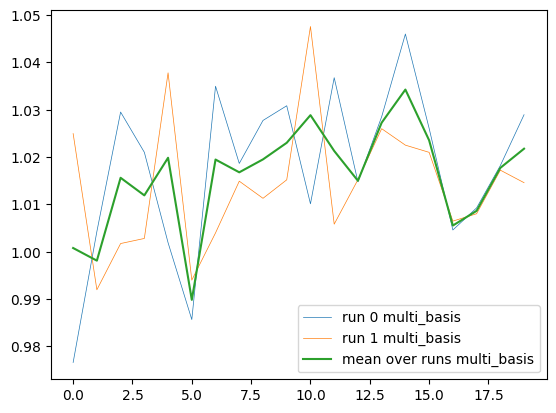

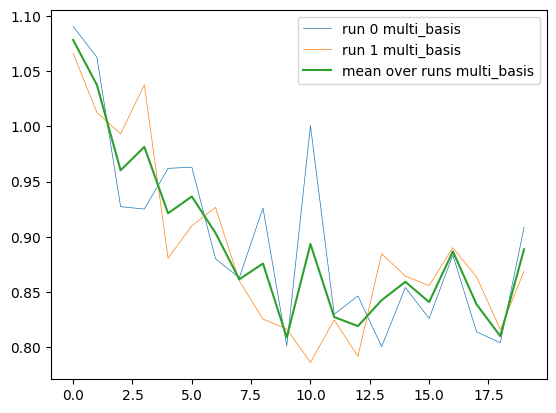

In [30]:

class SimpleHolder:
    def __init__(self, init_metrics, performance_diff, **kwargs):
        self.init_metrics = init_metrics
        self.performance_diff = performance_diff

        self.num_epochs = len(self.performance_diff)
        self.x_range = np.arange(self.num_epochs)

        self.perf_types = {
            'absolute': lambda x,y: x + y, 
            'diff': lambda x, y: x,
            'relative': lambda x, y: (x + y) / abs(x)
        }
    def get_results(self, keys = ('dice_score', ), number_type = 'absolute'):
        if keys is None:
            keys = self.init_metrics[0].keys()
        
        results = {key: [] for key in keys}
        for elem in self.performance_diff:
            for key in keys:
                results[key].append(self.perf_types[number_type](self.init_metrics[0][key], elem[key]))
        
        return results
    
    def get_absolute(self, keys = ('dice_score', )):
        return self.x_range, self.get_results(keys = keys, number_type='absolute')

    def get_diff(self, keys = ('dice_score', )):
        return self.x_range, self.get_results(keys = keys, number_type= 'diff')
    
    def get_relative(self, keys = ('dice_score', )):
        return self.x_range, self.get_results(keys = keys, number_type='relative')


def extract_and_plot(files, key = 'dice_score', only_mean = False, ax = None, fig = None, label = ""):

    if ax is None:
        fig, ax = plt.subplots(1,1)

    y_ranges = []
    for idx, file in enumerate(files):
        pcl = pickle.load(open(file, 'rb'))
        holder = SimpleHolder(**pcl)

        x_range, y_range = holder.get_relative(keys = (key, ))
        if not only_mean:
            ax.plot(x_range, y_range[key], linewidth = 0.5, label = f'run {idx} ' + label)
        y_ranges.append(y_range[key])

    ax.plot(x_range, np.median(np.array(y_ranges), axis = 0), label = 'mean over runs ' + label)
    ax.legend()
    return fig, ax 


fig, ax = extract_and_plot(results_files, key = 'dice_score', only_mean=False, label = 'multi_basis')
#fig, ax = extract_and_plot(results_files_basic, key = 'cross_entropy', only_mean=False, ax = ax, fig = fig, label = 'basic')
plt.show()
fig, ax = extract_and_plot(results_files, key = 'cross_entropy', only_mean=False, label = 'multi_basis')

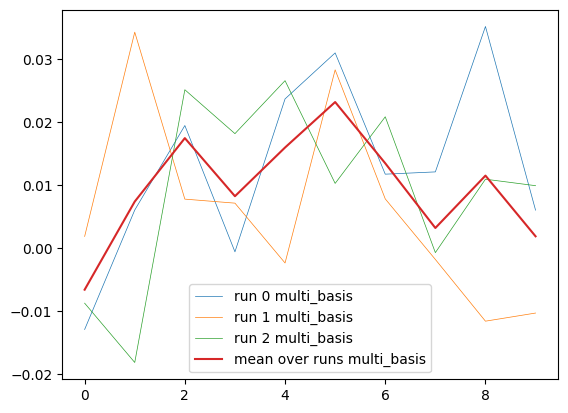

In [26]:
fig, ax = extract_and_plot(results_files, only_mean=False, label = 'multi_basis')
#fig, ax = extract_and_plot(results_files_basic, only_mean=False, ax = ax, fig = fig, label = 'basic')
plt.show()

In [3]:
directory = Path(results_path)

pickle_files = list(directory.rglob('*.pkl'))

In [4]:
pcl = pickle.load(open(pickle_files[0], 'rb'))
pcl.keys()

dict_keys(['init_metrics', 'training_kwargs', 'performance_diff', 'training_performance'])

In [5]:
pcl['training_kwargs']

[{'num_epochs': 10,
  'lr': 0.0001,
  'weight_decay': 0.0001,
  'output_dir': '/scratch/pjtka/ndseg_output/grid_search/ce_1.0_dice_0.5_kl_0.001',
  'num_iterations_per_epoch': 250,
  'num_val_iterations': 130,
  'loss_kwargs': {'lambda_ce': 1.0,
   'lambda_dice': 0.5,
   'lambda_nll': 1.0,
   'lambda_kl': 0.001}}]

Text(0.5, 1.0, 'Dice score')

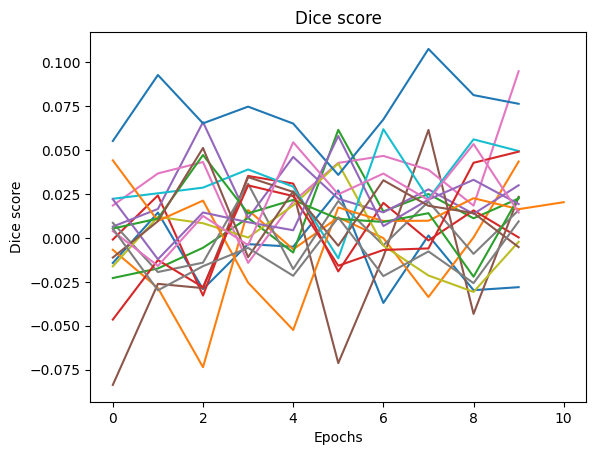

In [6]:

fig, ax = plt.subplots(1,1)
full_dice = np.zeros((len(pickle_files), 10))
full_ce = np.zeros_like(full_dice)
for idx, file in enumerate(pickle_files):
    pcl = pickle.load(open(file, 'rb'))
    performance = pcl['performance_diff']
    nll, dice = [],[]
    for elem in performance:
        nll.append(elem['cross_entropy'] / pcl['init_metrics'][0]['cross_entropy'])
        dice.append(elem['dice_score'])
    
    label = os.path.basename(file)
    epochs = range(len(dice))
    ax.plot(epochs, dice, label = label)
    full_dice[idx] = dice[:full_dice.shape[-1]]
    full_ce[idx] = nll[:full_ce.shape[-1]]

ax.set_xlabel('Epochs')
ax.set_ylabel('Dice score')
ax.set_title('Dice score')



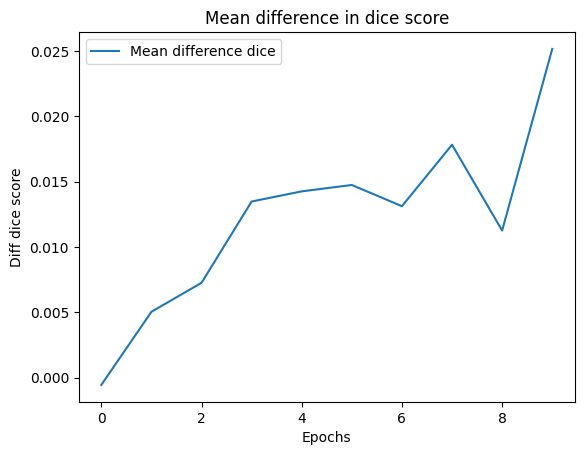

In [7]:
fig, ax = plt.subplots(1,1)


def plot_nice_line(ax, x_range, y_range, label = None, title = None, x_label = None, y_label = None, color = None):
    ax.plot(
        x_range, y_range, label = label, linewidth = 1.5
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    return ax

ax = plot_nice_line(ax, range(full_dice.shape[-1]), np.mean(full_dice, axis =0), label = 'Mean difference dice', x_label = 'Epochs', 
               y_label = 'Diff dice score', title = 'Mean difference in dice score')

ax.legend()

plt.show()

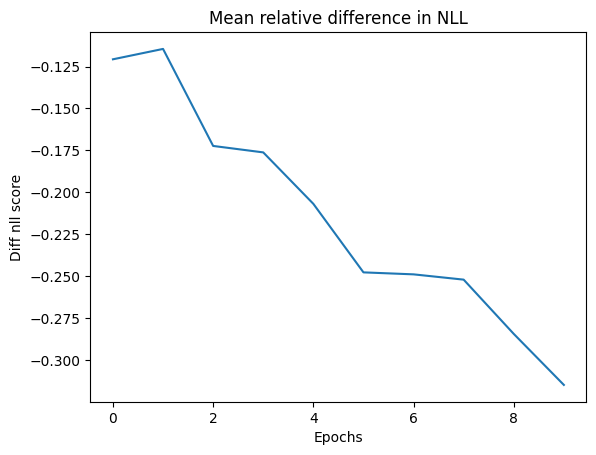

In [8]:
fig, ax = plt.subplots(1,1)
ax = plot_nice_line(ax, range(full_ce.shape[-1]), np.mean(full_ce, axis =0), label = 'Mean difference nll', x_label = 'Epochs', 
               y_label = 'Diff nll score', title = 'Mean relative difference in NLL')

plt.show()

In [12]:

def get_as_function_of(key = 'lambda_kl'):
    full_dice = np.zeros((len(pickle_files), 10))
    full_ce = np.zeros_like(full_dice)
    key_stat = []
    for idx, file in enumerate(pickle_files):
        pcl = pickle.load(open(file, 'rb'))
        performance = pcl['performance_diff']
        key_stat.append(pcl['training_kwargs'][0]['loss_kwargs'][key])
        nll, dice = [],[]
        for elem in performance:
            nll.append(elem['cross_entropy'] / pcl['init_metrics'][0]['cross_entropy'])
            dice.append(elem['dice_score'])
        
        label = os.path.basename(file)
        epochs = range(len(dice))
        ax.plot(epochs, dice, label = label)
        full_dice[idx] = dice[:full_dice.shape[-1]]
        full_ce[idx] = nll[:full_ce.shape[-1]]

    return full_dice, full_ce, np.array(key_stat)


fd, fce, kl = get_as_function_of(key = 'lambda_dice')

In [2]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.path.dirname('/home/pjtka/ndsegment/NDSegRef/uncertainty/plotting.ipynb')), 'nnunet'))
from TotalSegmentator.utils.get_data_loader import get_data_loader
train, test = get_data_loader()

/scratch/pjtka/NDSegUnc/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/scratch/pjtka/NDSegUnc/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-09-01 15:59:33.950645: do_dummy_2d_data_aug: False
2025-09-01 15:59:33.952773: Using splits from existing split file: /scratch/pjtka/nnUNet/nnUNet_preprocessed/Dataset004_TotalSegmentatorPancreas/splits_final.json
2025-09-01 15:59:33.954857: The split file contains 5 splits.
2025-09-01 15:59:33.955680: Desired fold for training: 0
2025-09-01 15:59:33.956351: This split has 518 training and 130 validation cases.
using pin_memory on device 0
using pin_memory on device 0


In [9]:
import pickle

save_path = '/scratch/pjtka/pancreas_validation'
identifiers = test.generator._data.identifiers
has_been_saved = {key: False for key in identifiers}
os.makedirs(save_path, exist_ok=True)


In [6]:
elem = next(iter(test))

In [8]:
elem.keys()

dict_keys(['data', 'target', 'keys'])

In [10]:


while not all(has_been_saved.values()):
    elem = next(iter(test))
    key = elem['keys'][0]
    if has_been_saved[key]:
        continue

    filename = os.path.join(save_path, elem['keys'][0]+".pkl")

    with open(filename, 'wb') as handle:
        pickle.dump(elem, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    has_been_saved[key] = True

    

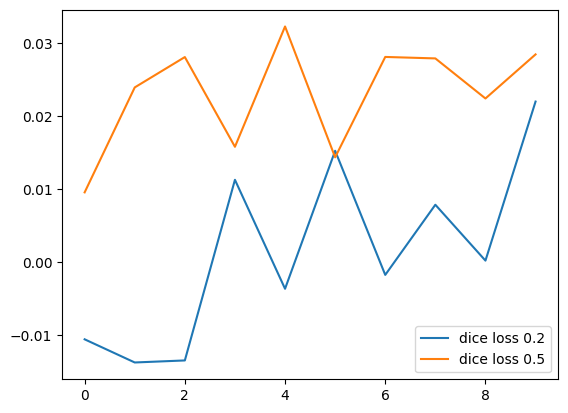

In [15]:

plot_fd, plot_ce = [], []
fig, ax = plt.subplots(1,1)
for val in np.unique(kl):
    fd_sub = fd[kl == val]
    fce_sub = fce[kl == val]
    plot_fd.append(np.mean(fd_sub, axis = 0))
    plot_ce.append(np.mean(fce_sub, axis = 0))

    ax.plot(range(plot_ce[-1].shape[-1]), plot_fd[-1], label = f'dice loss {val}')

ax.legend()
plt.show()


In [5]:
import torch

size = torch.Tensor((2, 1, 200, 200, 200))

mu = torch.rand((2, torch.prod(size[1:]).int().item()))
diag = torch.exp(torch.rand((2, torch.prod(size[1:]).int().item())))
low_rank = torch.randn((2, torch.prod(size[1:]).int().item(), 16))

dist = torch.distributions.LowRankMultivariateNormal(mu, low_rank, diag)




In [38]:
C = 2
r = 16
D,H,W = (25,25,25)
Bsize= 1
B = torch.randn((C,r))
A = torch.randn((Bsize,C,r, D,H,W))

In [36]:

import pickle 
import os
import matplotlib.pyplot as plt
import numpy as np 

class Holder:

    def __init__(self, basis_path, exp_name):
        
        self.basis_path = basis_path 
        self.exp_name = exp_name
        
        self.files_test, self.files_val = {}, {}

        all_files = os.listdir(self.basis_path)
        for file in all_files:
            if file.startswith(exp_name) and file.endswith('pkl'):
                if 'test' in file:
                    run_number = int(file.split("_")[-3])
                    self.files_test[run_number]  = os.path.join(basis_path, file)
                else:
                    run_number = int(file.split("_")[-2])
                    self.files_val[run_number]  = os.path.join(basis_path, file)

        
        self.holders = []
        for key, val in self.files_test.items():
            if key in self.files_val:
                self.holders.append(MiniHolder(self.files_val[key], val))

    
        
    def plot_max_performance(self, score = 'dice_score', ax = None, name = None):

        x_vals = range(len(self.holders))
        y_vals = [holder.get_max(score) for holder in self.holders]
        
        if ax is None:
            fig, ax = plt.subplots(1,1)
        
        if name is None:
            name = self.exp_name
        
        ax.scatter(x_vals, y_vals, s = 20,label = name)
        return ax
    
    def plot_mean_performance(self, score = 'dice_score', ax = None, name = None, index = 0):

        y_vals = [holder.get_max(score) for holder in self.holders]
        
        if ax is None:
            fig, ax = plt.subplots(1,1)
        if name is None:
            name = self.exp_name
        
        ax.errorbar(index, np.mean(y_vals), yerr = np.std(y_vals), label = name, fmt = "*")
        return ax


class MiniHolder:

    def __init__(self, val_path, test_path):
        self.val_path = val_path 
        self.test_path = test_path
        
        self.val = self.open(self.val_path)
        self.test = self.open(self.test_path)

        self.indices = self.find_indices()
        self.all_tests = self.get_score(self.test)

    def get_max(self, score = 'dice_score', get_min = False):
        results = self.get_score(self.test, score = score)
        return max(results) if not get_min else min(results)

    
    def open(self, path):
        return pickle.load(open(path, 'rb'))
    
    def get_score(self, res, score = 'dice_score'):
        perf = res['performance_diff']
        return [p[score] for p in perf]

    def find_indices(self, ):
        
        performance_diff = self.val['training_performance']
        dice = [perf['dice_score'] for perf in performance_diff]
        indices_for_test = []
        best_performance = -1
        for idx in range(len(dice)):
            if dice[idx] > best_performance:
                indices_for_test.append(idx)
                best_performance = dice[idx]
        
        return indices_for_test
    

basis_path = '/scratch/pjtka/ndseg_output/pancreas_final_run'
exp_name = 'basic'
exp_name_two = 'multi_basis'

basic = Holder(basis_path=basis_path, exp_name=exp_name)
multi = Holder(basis_path=basis_path, exp_name=exp_name_two)

    

In [18]:
y_vals = [holder.get_max('dice_score') for holder in basic.holders]
y_vals

[0.8578438758850098,
 0.8351935744285583,
 0.8309224247932434,
 0.8480799198150635,
 0.8472872376441956]

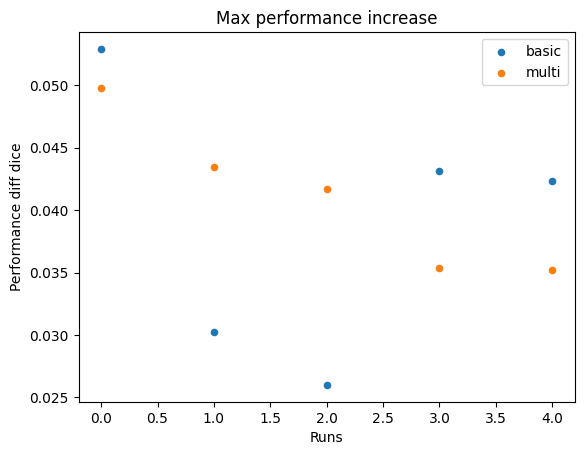

In [32]:
fig, ax = plt.subplots(1,1)

ax = basic.plot_max_performance(ax = ax, name = 'basic')
ax = multi.plot_max_performance(ax = ax,  name = 'multi')
ax.set_title('Max performance increase')
ax.set_xlabel('Runs')
ax.set_ylabel('Performance diff dice')
ax.legend()

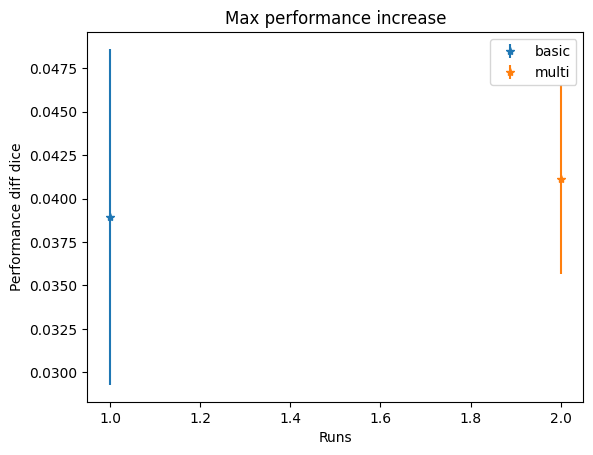

In [37]:
fig, ax = plt.subplots(1,1)

ax = basic.plot_mean_performance(ax = ax, index=1, name = 'basic')
ax = multi.plot_mean_performance(ax = ax, index=2, name = 'multi')
ax.set_title('Max performance increase')
ax.set_xlabel('Runs')
ax.set_ylabel('Performance diff dice')
ax.legend()